In [1]:
import pandas as pd
import json
from dotenv import load_dotenv
import os
import time
from discharge_agent.llm.llm_utils import LLMProvider, MedicalDataExtractor
from discharge_agent.extractions.extraction import run_extraction_with_json_evaluation

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

df = pd.read_csv("data/synthetic_notes.csv")

In [2]:


# Local setup
oss_extractor = MedicalDataExtractor(
    LLMProvider.LOCAL,
    model="gpt-oss:20b",
    api_url="http://localhost:11434/api/chat"
)
mistral_extractor = MedicalDataExtractor(
    LLMProvider.LOCAL,
    model="mistral-small:22b",
    api_url="http://localhost:11434/api/chat"
)

# OpenAI setup  
gpt5_extractor = MedicalDataExtractor(
    LLMProvider.OPENAI,
    api_key=OPENAI_API_KEY,
    model="gpt-5-2025-08-07"
)

gpt5mini_extractor = MedicalDataExtractor(
    LLMProvider.OPENAI,
    api_key=OPENAI_API_KEY,
    model="gpt-5-mini-2025-08-07"
)

gpt41_extractor = MedicalDataExtractor(
    LLMProvider.OPENAI,
    api_key=OPENAI_API_KEY,
    model="gpt-4.1-2025-04-14"
)

# Anthropic setup
opus_extractor = MedicalDataExtractor(
    LLMProvider.ANTHROPIC,
    api_key=ANTHROPIC_API_KEY, 
    model="claude-opus-4-1-20250805"
)

sonnet_extractor = MedicalDataExtractor(
    LLMProvider.ANTHROPIC,
    api_key=ANTHROPIC_API_KEY, 
    model="claude-sonnet-4-20250514"
)

haiku_extractor = MedicalDataExtractor(
    LLMProvider.ANTHROPIC,
    api_key=ANTHROPIC_API_KEY, 
    model="claude-3-5-haiku-20241022"
)

In [3]:
benchmark_models = {
    "claude_sonnet": sonnet_extractor,
    "claude_opus": opus_extractor,
    "claude_haiku": haiku_extractor,
    "openai_gpt5": gpt5_extractor,
    "openai_gpt5mini": gpt5mini_extractor,
    "openai_gpt4_1": gpt41_extractor,
    "openai_oss": oss_extractor,
    "mistral_small": mistral_extractor
}

In [ ]:
timing_results = {}
all_results = {}
summary_results = {}
for model, extractor in benchmark_models.items():
    print(f"Extracting data with : {model}")
    start_time = time.time()
    results, summary = run_extraction_with_json_evaluation(df, extractor)
    end_time = time.time()
    timing_results[model] = end_time - start_time
    all_results[model] = results
    summary_results[model] = summary

In [ ]:
with open("data/processed_notes/all_extractions_multiple_providers.jsonl", "w") as f:
    for i in range(len(all_results)):
        note_extraction = {}
        for model, result in all_results.items():
            note_extraction[model] = result[i]
            
        f.write(json.dumps(note_extraction) + "\n")

In [ ]:
# Read data for eval
data = []
with open("data/processed_notes/all_extractions_multiple_providers.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))
data

In [19]:
#Using consensus:
import re
from collections import Counter, defaultdict
from statistics import median
from typing import Any, Dict, List, Tuple

# ---- Normalizers ----
def ntext(x: Any) -> str:
    s = "" if x is None else str(x).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def ndate(x: Any) -> str:
    if not x: return ""
    s = str(x).strip()
    m = re.match(r"^(\d{4})[-/](\d{2})[-/](\d{2})$", s)
    if m: return f"{m.group(1)}-{m.group(2)}-{m.group(3)}"
    m = re.match(r"^(\d{2})/(\d{2})/(\d{4})$", s)
    if m: return f"{m.group(3)}-{m.group(1)}-{m.group(2)}"
    m = re.match(r"^(\d{2})/(\d{2})$", s)
    if m: return f"0000-{m.group(1)}-{m.group(2)}"
    return s  # keep other formats as-is (e.g., "03/01 0600")

def ntime(x: Any) -> str:
    if not x: return ""
    s = str(x).strip().lower().replace(" ", "")
    m = re.search(r"(\d{1,2}):(\d{2})(am|pm)", s)
    if m:
        h = int(m.group(1)); mi = int(m.group(2)); ap = m.group(3)
        if ap == "pm" and h != 12: h += 12
        if ap == "am" and h == 12: h = 0
        return f"{h:02d}:{mi:02d}"
    m = re.search(r"^(\d{1,2}):(\d{2})$", s)
    if m: return f"{int(m.group(1)):02d}:{int(m.group(2)):02d}"
    return s

# Optional: simple lab synonym map for better merge (extend as needed)
LAB_SYNONYM = {
    "trop i": "troponin i",
    "chol": "cholesterol",
    "tg": "triglycerides",
}
def canon_lab_name(n: str) -> str:
    n2 = ntext(n)
    return LAB_SYNONYM.get(n2, n2)

# ---- Keys for set-like matching ----
def meds_key(x): return (ntext(x.get("name","")), ntext(x.get("dose","")), ntext(x.get("frequency","")))
def fup_key(x):  return (ntext(x.get("provider","")), ntext(x.get("specialty","")), ndate(x.get("date","")), ntime(x.get("time","")))

def proc_to_dict(x):
    if isinstance(x, str):
        return {"name": x, "date": ""}
    return {"name": (x.get("name") or x.get("procedure") or ""), "date": x.get("date","")}

def proc_key(x): 
    d = proc_to_dict(x)
    return (ntext(d["name"]), ndate(d["date"]))

# ---- Majority chooser for scalars ----
def majority_value(values: List[str]) -> str:
    vals = [v for v in values if v]
    if not vals: return ""
    cnt = Counter(vals)
    top, freq = cnt.most_common(1)[0]
    # tie-break: longest non-empty
    ties = [v for v,c in cnt.items() if c == freq]
    return max(ties, key=len)

# ---- Consensus for a single note ----
def consensus_for_note(note_outputs: Dict[str, Dict], quorum: float = 0.5) -> Dict:
    models = list(note_outputs.values())
    mcount = max(1, len(models))
    need = max(1, int(round(quorum * mcount)))

    gold = {
        "discharge_date": "",
        "chief_complaint": "",
        "primary_discharge_diagnosis": "",
        "discharge_disposition": "",
        "procedures_performed": [],
        "discharge_condition": {},
        "medication_changes": {"new_medications": [], "dose_changes": []},
        "follow_up_appointments": [],
        "most_recent_labs": [],
    }

    # Scalars (majority)
    scalar_fields = ["discharge_date","chief_complaint","primary_discharge_diagnosis","discharge_disposition"]
    for f in scalar_fields:
        vals = []
        for out in models:
            v = out.get(f,"")
            vals.append(ndate(v) if f=="discharge_date" else ntext(v))
        gold[f] = majority_value(vals)

    # Labs (per name; numeric -> median; else mode). Require quorum on *name* presence.
    name_to_vals = defaultdict(list)
    for out in models:
        for lab in (out.get("most_recent_labs") or []):
            name = canon_lab_name(lab.get("name",""))
            if not name: continue
            value = str(lab.get("value","")).strip()
            name_to_vals[name].append(value)

    labs_consensus = []
    for name, vals in name_to_vals.items():
        if len(vals) < need: 
            continue
        # numeric median if possible, else mode
        nums = []
        for v in vals:
            m = re.findall(r"-?\d+\.?\d*", v)
            nums.append(float(m[0])) if m else None
        if sum(1 for v in vals if re.search(r"-?\d+\.?\d*", v)) >= need:
            # enough numeric reports -> median
            num_vals = [float(re.findall(r"-?\d+\.?\d*", v)[0]) for v in vals if re.search(r"-?\d+\.?\d*", v)]
            val = str(median(num_vals))
        else:
            val = Counter([ntext(v) for v in vals if v]).most_common(1)[0][0]
        labs_consensus.append({"name": name, "value": val})
    gold["most_recent_labs"] = labs_consensus

    # New medications (quorum on exact triple)
    med_counts = Counter()
    med_example = {}
    for out in models:
        for m in ((out.get("medication_changes") or {}).get("new_medications") or []):
            k = meds_key(m)
            med_counts[k] += 1
            med_example[k] = {"name": k[0], "dose": k[1], "frequency": k[2]}
    gold["medication_changes"]["new_medications"] = [med_example[k] for k,c in med_counts.items() if c >= need]

    # Follow-ups (quorum on tuple)
    fup_counts = Counter()
    fup_example = {}
    for out in models:
        for fu in (out.get("follow_up_appointments") or []):
            k = fup_key(fu)
            fup_counts[k] += 1
            fup_example[k] = {"provider": k[0], "specialty": k[1], "date": k[2], "time": k[3]}
    gold["follow_up_appointments"] = [fup_example[k] for k,c in fup_counts.items() if c >= need]

    # Procedures (string or dict; quorum on tuple)
    proc_counts = Counter()
    proc_example = {}
    for out in models:
        for p in (out.get("procedures_performed") or []):
            k = proc_key(p)
            proc_counts[k] += 1
            d = proc_to_dict(p)
            proc_example[k] = {"name": d["name"], "date": d["date"]}
    gold["procedures_performed"] = [proc_example[k] for k,c in proc_counts.items() if c >= need]

    # (optional) Discharge condition: naive union of most common keys/values
    dc_kv = defaultdict(list)
    for out in models:
        for k,v in (out.get("discharge_condition") or {}).items():
            dc_kv[k].append(ntext(v))
    gold["discharge_condition"] = {k: Counter(vs).most_common(1)[0][0] for k,vs in dc_kv.items() if len(vs) >= need}

    return gold

# ---- Build consensus for all notes ----
def consensus_gold_all(data: List[Dict[str, Dict]], quorum: float = 0.5) -> List[Dict]:
    return [consensus_for_note(note_models, quorum=quorum) for note_models in data]

# Example:
# gold_consensus = consensus_gold_all(data, quorum=0.5)
# # Save if you like:
# import json, pathlib
# pathlib.Path("gold_notes.jsonl").write_text("\n".join(json.dumps(g) for g in gold_consensus))


In [20]:
gold_consensus = consensus_gold_all(data, quorum=0.5)

In [21]:
import re
from typing import Any, Dict, List, Tuple
from collections import Counter, defaultdict
import pandas as pd

SCALAR_FIELDS = ["discharge_date","chief_complaint","primary_discharge_diagnosis","discharge_disposition"]

def ntext(x: Any) -> str:
    s = "" if x is None else str(x).strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = s.replace(" ;", ";").replace(" ,", ",")
    return s

def ndate(x: Any) -> str:
    if not x: return ""
    s = str(x).strip()
    m = re.match(r"^(\d{4})[-/](\d{2})[-/](\d{2})$", s)
    if m: return f"{m.group(1)}-{m.group(2)}-{m.group(3)}"
    m = re.match(r"^(\d{2})/(\d{2})/(\d{4})$", s)
    if m: return f"{m.group(3)}-{m.group(1)}-{m.group(2)}"
    m = re.match(r"^(\d{2})/(\d{2})$", s)
    if m: return f"0000-{m.group(1)}-{m.group(2)}"
    return s

def ntime(x: Any) -> str:
    if not x: return ""
    s = str(x).strip().lower().replace(" ", "")
    m = re.search(r"(\d{1,2}):(\d{2})(am|pm)", s)
    if m:
        h = int(m.group(1)); mi = int(m.group(2)); ap = m.group(3)
        if ap == "pm" and h != 12: h += 12
        if ap == "am" and h == 12: h = 0
        return f"{h:02d}:{mi:02d}"
    m = re.search(r"^(\d{1,2}):(\d{2})$", s)
    if m: return f"{int(m.group(1)):02d}:{int(m.group(2)):02d}"
    return s

def tok_jacc(a: str, b: str) -> float:
    A = set(re.findall(r"[a-z0-9]+", a.lower()))
    B = set(re.findall(r"[a-z0-9]+", b.lower()))
    if not A and not B: return 1.0
    if not A or not B: return 0.0
    return len(A & B) / len(A | B)

def parse_float(s: str):
    try:
        return True, float(re.findall(r"-?\d+\.?\d*", str(s))[0])
    except Exception:
        return False, float("nan")

def norm_scalar(field, v):
    return ndate(v) if field=="discharge_date" else ntext(v)

def scalar_scores(pred: Dict, gold: Dict) -> Dict[str, float]:
    out = {}
    for f in SCALAR_FIELDS:
        p = norm_scalar(f, pred.get(f,""))
        g = norm_scalar(f, gold.get(f,""))
        out[f+"_exact"] = 1.0 if (p == g and g != "") else 0.0
        out[f+"_soft"]  = 1.0 if (tok_jacc(p,g) >= 0.8 and g != "") else 0.0
    out["scalar_exact_acc"] = sum(out[f+"_exact"] for f in SCALAR_FIELDS)/len(SCALAR_FIELDS)
    out["scalar_soft_acc"]  = sum(out[f+"_soft"]  for f in SCALAR_FIELDS)/len(SCALAR_FIELDS)
    return out

def lab_key(x):  return ntext(x.get("name","")), str(x.get("value","")).strip()
def meds_key(x): return ntext(x.get("name","")), ntext(x.get("dose","")), ntext(x.get("frequency",""))
def fup_key(x):  return ntext(x.get("provider","")), ntext(x.get("specialty","")), ndate(x.get("date","")), ntime(x.get("time",""))
def proc_key(x): return ntext(x.get("name","") or x.get("procedure","")), ndate(x.get("date",""))

# Normalize gold procedures that are strings -> dicts
def normalize_gold_proc(g):
    procs = []
    for x in (g.get("procedures_performed") or []):
        if isinstance(x, dict): procs.append(x)
        else: procs.append({"name": x, "date": ""})
    g = dict(g); g["procedures_performed"] = procs
    return g

def proc_key(x):
    # Accept dict or string
    if isinstance(x, str):
        name = x
        date = ""
    else:
        name = (x.get("name") or x.get("procedure") or "")
        date = x.get("date", "")
    return ntext(name), ndate(date)

def normalize_procs_list(lst):
    """Turn list of str/dict into list of dicts with {name, date}."""
    out = []
    for x in (lst or []):
        if isinstance(x, str):
            out.append({"name": x, "date": ""})
        elif isinstance(x, dict):
            out.append({"name": x.get("name") or x.get("procedure") or "",
                        "date": x.get("date", "")})
    return out

def f1_list(pred_list: List[Dict], gold_list: List[Dict], kind: str) -> Tuple[int,int,int,float,float,float]:
    if kind == "labs":
        # tolerant on numeric values: ±1.0 or ±5%
        gold_map = defaultdict(list)
        for x in (gold_list or []):
            k = ntext(x.get("name","")); gold_map[k].append(str(x.get("value","")).strip())
        tp = 0; used = set()
        for x in (pred_list or []):
            kname = ntext(x.get("name","")); pval = str(x.get("value","")).strip()
            for gv in gold_map.get(kname, []):
                if (kname, gv) in used: 
                    continue
                ok_p, pv = parse_float(pval); ok_g, gvf = parse_float(gv)
                if ok_p and ok_g:
                    if (abs(pv-gvf) <= 1.0) or (gvf != 0 and abs(pv-gvf)/abs(gvf) <= 0.05):
                        tp += 1; used.add((kname, gv)); break
                else:
                    if ntext(pval) == ntext(gv):
                        tp += 1; used.add((kname, gv)); break
        fp = len(pred_list or []) - tp; fn = len(gold_list or []) - tp
    else:
        if kind == "meds":
            P = set(meds_key(x) for x in (pred_list or []))
            G = set(meds_key(x) for x in (gold_list or []))
        elif kind == "followups":
            P = set(fup_key(x) for x in (pred_list or []))
            G = set(fup_key(x) for x in (gold_list or []))
        elif kind == "procedures":
            P = set(proc_key(x) for x in (pred_list or []))
            G = set(proc_key(x) for x in (gold_list or []))
        else:
            P = set(); G = set()
        tp = len(P & G); fp = len(P - G); fn = len(G - P)
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    return tp, fp, fn, prec, rec, f1

In [22]:
# ---- Run eval ----
scalar_rows=[]; list_rows=[]

for note_idx, (note_preds, gold_note_raw) in enumerate(zip(data, gold_consensus)):
    gold_note = normalize_gold_proc(gold_note_raw)
    for model, pred in note_preds.items():
        s = scalar_scores(pred, gold_note); s["model"]=model; s["note_idx"]=note_idx
        scalar_rows.append(s)

        labs_pred = pred.get("most_recent_labs", []) or []
        labs_gold = gold_note.get("most_recent_labs", []) or []
        meds_pred = (pred.get("medication_changes",{}) or {}).get("new_medications", []) or []
        meds_gold = (gold_note.get("medication_changes",{}) or {}).get("new_medications", []) or []
        fup_pred  = pred.get("follow_up_appointments", []) or []
        fup_gold  = gold_note.get("follow_up_appointments", []) or []
        proc_pred = pred.get("procedures_performed", []) or []
        proc_gold = gold_note.get("procedures_performed", []) or []

        tp_l, fp_l, fn_l, p_l, r_l, f1_l = f1_list(labs_pred, labs_gold, "labs")
        tp_m, fp_m, fn_m, p_m, r_m, f1_m = f1_list(meds_pred, meds_gold, "meds")
        tp_f, fp_f, fn_f, p_f, r_f, f1_f = f1_list(fup_pred, fup_gold, "followups")
        tp_p, fp_p, fn_p, p_p, r_p, f1_p = f1_list(proc_pred, proc_gold, "procedures")

        # Micro across lists (TP/FP/FN summed)
        TP = tp_l + tp_m + tp_f + tp_p
        FP = fp_l + fp_m + fp_f + fp_p
        FN = fn_l + fn_m + fn_f + fn_p
        p_all = TP/(TP+FP) if (TP+FP)>0 else 0.0
        r_all = TP/(TP+FN) if (TP+FN)>0 else 0.0
        f1_all = 2*p_all*r_all/(p_all+r_all) if (p_all+r_all)>0 else 0.0

        list_rows.append({
            "model": model, "note_idx": note_idx,
            "labs_p": p_l, "labs_r": r_l, "labs_f1": f1_l,
            "meds_p": p_m, "meds_r": r_m, "meds_f1": f1_m,
            "followups_p": p_f, "followups_r": r_f, "followups_f1": f1_f,
            "procedures_p": p_p, "procedures_r": r_p, "procedures_f1": f1_p,
            "all_lists_p": p_all, "all_lists_r": r_all, "all_lists_f1": f1_all,
        })

df_scalar = pd.DataFrame(scalar_rows)
df_lists  = pd.DataFrame(list_rows)

# Aggregate per model
def agg_mean(df, cols, by="model"):
    if df.empty: return pd.DataFrame(columns=[by]+cols)
    return df.groupby(by)[cols].mean().reset_index()

scalar_cols = [f"{f}_exact" for f in SCALAR_FIELDS] + [f"{f}_soft" for f in SCALAR_FIELDS] + ["scalar_exact_acc","scalar_soft_acc"]
list_cols = ["labs_p","labs_r","labs_f1","meds_p","meds_r","meds_f1","followups_p","followups_r","followups_f1","procedures_p","procedures_r","procedures_f1","all_lists_p","all_lists_r","all_lists_f1"]
agg_scalar = agg_mean(df_scalar, scalar_cols)
agg_lists  = agg_mean(df_lists, list_cols)
summary = agg_scalar.merge(agg_lists, on="model", how="outer").sort_values("all_lists_f1", ascending=False)

print("=== SUMMARY (per model, averaged over the 10 notes) ===")
print(summary.to_string(index=False))

=== SUMMARY (per model, averaged over the 10 notes) ===
          model  discharge_date_exact  chief_complaint_exact  primary_discharge_diagnosis_exact  discharge_disposition_exact  discharge_date_soft  chief_complaint_soft  primary_discharge_diagnosis_soft  discharge_disposition_soft  scalar_exact_acc  scalar_soft_acc   labs_p   labs_r  labs_f1   meds_p   meds_r  meds_f1  followups_p  followups_r  followups_f1  procedures_p  procedures_r  procedures_f1  all_lists_p  all_lists_r  all_lists_f1
  openai_gpt4_1                   1.0                    1.0                                1.0                          1.0                  1.0                   1.0                               1.0                         1.0             1.000              1.0 0.870476 0.907143 0.886941 1.000000 1.000000 1.000000         0.90         0.95      0.916667          0.40           0.4       0.400000     0.925065     0.949650      0.936776
openai_gpt5mini                   1.0                    1.0

In [27]:
summary

,model,discharge_date_exact,chief_complaint_exact,primary_discharge_diagnosis_exact,discharge_disposition_exact,discharge_date_soft,chief_complaint_soft,primary_discharge_diagnosis_soft,discharge_disposition_soft,scalar_exact_acc,...,meds_f1,followups_p,followups_r,followups_f1,procedures_p,procedures_r,procedures_f1,all_lists_p,all_lists_r,all_lists_f1
4,openai_gpt4_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,...,1.000000,0.90,0.95,0.916667,0.40,0.4,0.400000,0.925065,0.949650,0.936776
6,openai_gpt5mini,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,...,0.800000,0.85,0.95,0.883333,0.35,0.4,0.366667,0.885338,0.937479,0.908050
5,openai_gpt5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,...,0.900000,0.85,0.95,0.883333,0.40,0.4,0.400000,0.903791,0.899389,0.894113
2,claude_sonnet,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,...,0.865714,0.95,1.00,0.966667,0.20,0.2,0.200000,0.938162,0.805940,0.844437
1,claude_opus,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,...,0.558333,0.90,0.95,0.916667,0.40,0.4,0.400000,0.791587,0.759759,0.772567
0,claude_haiku,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,...,0.683333,0.80,0.85,0.816667,0.00,0.0,0.000000,0.748305,0.673861,0.694211
7,openai_oss,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,...,0.200000,0.75,0.85,0.783333,0.20,0.2,0.200000,0.576703,0.577939,0.574252
3,mistral_small,1.0,1.0,0.9,1.0,1.0,1.0,1.0,1.0,0.975,...,0.350000,0.35,0.35,0.350000,0.40,0.4,0.400000,0.677808,0.501091,0.567656


# Visualization

In [ ]:
#TODO: Put this in scripts, out of the notebook and PR

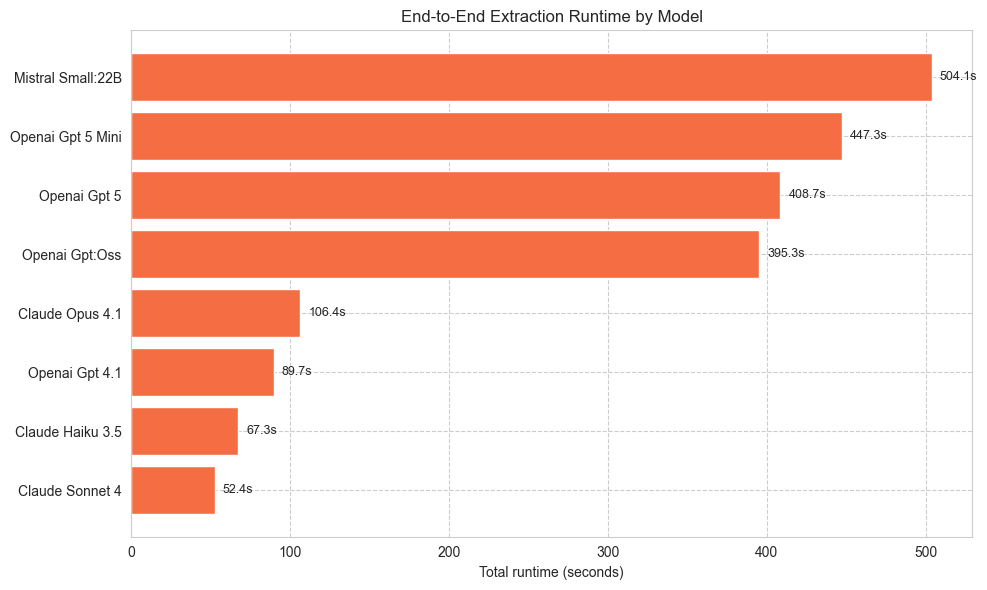

In [24]:
# Retry: generate the horizontal bar chart for model timings.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid", {'grid.linestyle': '--'})


timings = {
 'OpenAI GPT 4.1': 89.69415211677551,
 'OpenAI GPT 5': 408.66400814056396,
 'OpenAI GPT 5-mini': 447.3474760055542,
 'OpenAI gpt:oss': 395.32504415512085,
 'Claude Opus 4.1': 106.3530433177948,
 'Claude Sonnet 4': 52.438400983810425,
 'Claude Haiku 3.5': 67.34768104553223,
 'Mistral small:22b': 504.06847310066223
}

df = pd.DataFrame(list(timings.items()), columns=["model","seconds"]).sort_values("seconds").reset_index(drop=True)
df["label"] = df["model"].str.replace("_"," ").str.replace("-"," ").str.title()

fig, ax = plt.subplots(figsize=(10,6))
y = np.arange(len(df))
ax.barh(y, df["seconds"].values, color="#f46d43")

for yi, val in zip(y, df["seconds"].values):
    ax.text(val + df["seconds"].max()*0.01, yi, f"{val:.1f}s", va="center", fontsize=9)

ax.set_yticks(y)
ax.set_yticklabels(df["label"])
ax.set_xlabel("Total runtime (seconds)")
ax.set_title("End-to-End Extraction Runtime by Model")

fig.tight_layout()

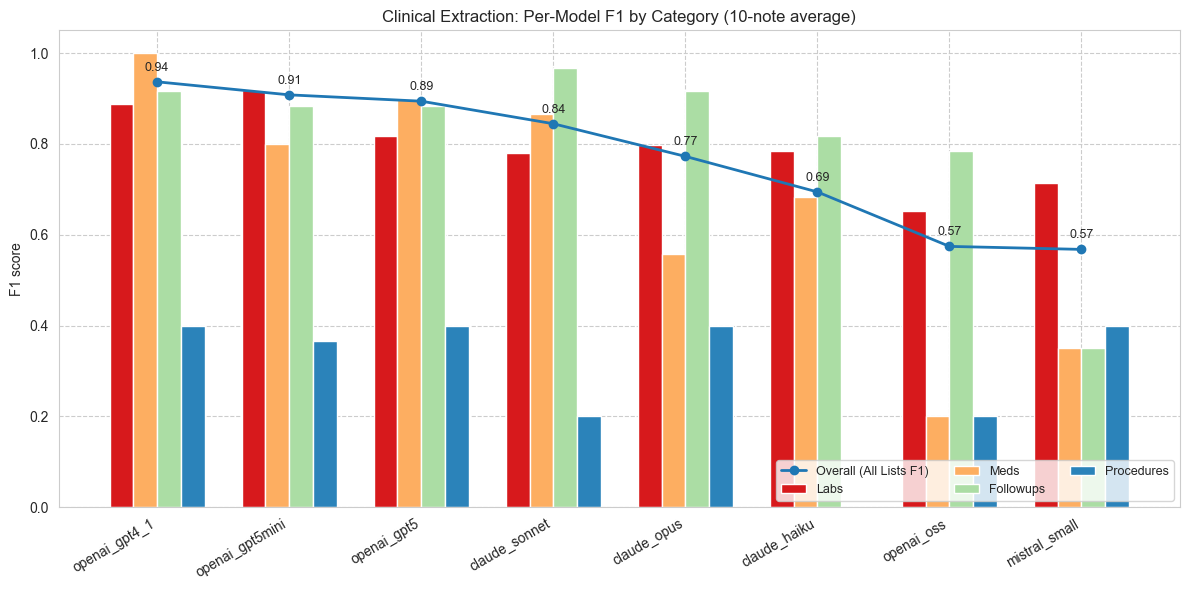

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rows = [
    {"model":"openai_gpt4_1",   "labs_f1":0.886941, "meds_f1":1.000000, "followups_f1":0.916667, "procedures_f1":0.400000, "all_lists_f1":0.936776},
    {"model":"openai_gpt5mini", "labs_f1":0.918137, "meds_f1":0.800000, "followups_f1":0.883333, "procedures_f1":0.366667, "all_lists_f1":0.908050},
    {"model":"openai_gpt5",     "labs_f1":0.818260, "meds_f1":0.900000, "followups_f1":0.883333, "procedures_f1":0.400000, "all_lists_f1":0.894113},
    {"model":"claude_sonnet",   "labs_f1":0.779365, "meds_f1":0.865714, "followups_f1":0.966667, "procedures_f1":0.200000, "all_lists_f1":0.844437},
    {"model":"claude_opus",     "labs_f1":0.797911, "meds_f1":0.558333, "followups_f1":0.916667, "procedures_f1":0.400000, "all_lists_f1":0.772567},
    {"model":"claude_haiku",    "labs_f1":0.783974, "meds_f1":0.683333, "followups_f1":0.816667, "procedures_f1":0.000000, "all_lists_f1":0.694211},
    {"model":"openai_oss",      "labs_f1":0.652020, "meds_f1":0.200000, "followups_f1":0.783333, "procedures_f1":0.200000, "all_lists_f1":0.574252},
    {"model":"mistral_small",   "labs_f1":0.713253, "meds_f1":0.350000, "followups_f1":0.350000, "procedures_f1":0.400000, "all_lists_f1":0.567656},
]
df2 = pd.DataFrame(rows).sort_values("all_lists_f1", ascending=False).reset_index(drop=True)
df = summary[['model', 'labs_f1', 'meds_f1', 'followups_f1', 'procedures_f1', 'all_lists_f1']].sort_values(by='all_lists_f1', ascending=False).reset_index(drop=True)

metrics = ["labs_f1", "meds_f1", "followups_f1", "procedures_f1"]
x = np.arange(len(df))
width = 0.18

palette = {
    0: "#d7191c",
    1: "#fdae61",
    2: "#abdda4",
    3: "#2b83ba"
}

fig, ax = plt.subplots(figsize=(12,6))
for i, m in enumerate(metrics):
    color = palette[i]
    ax.bar(x + (i-1.5)*width, df[m].values, width, color=color, label=m.replace("_f1","").title())

ax.plot(x, df["all_lists_f1"].values, marker="o", linewidth=2, label="Overall (All Lists F1)")

ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(df["model"], rotation=30, ha="right")
ax.set_ylabel("F1 score")
ax.set_title("Clinical Extraction: Per-Model F1 by Category (10-note average)")

for xi, yi in zip(x, df["all_lists_f1"].values):
    ax.annotate(f"{yi:.2f}", (xi, yi), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9)

ax.legend(ncol=3, fontsize=9, frameon=True, loc="lower right")
plt.tight_layout()

In [ ]:
df = summary[['model', 'labs_f1', 'meds_f1', 'followups_f1', 'procedures_f1', 'all_lists_f1']].sort_values(by='all_lists_f1', ascending=False).reset_index(drop=True)

In [29]:
df

,model,labs_f1,meds_f1,followups_f1,procedures_f1,all_lists_f1
0,openai_gpt4_1,0.886941,1.000000,0.916667,0.400000,0.936776
1,openai_gpt5mini,0.918137,0.800000,0.883333,0.366667,0.908050
2,openai_gpt5,0.818260,0.900000,0.883333,0.400000,0.894113
3,claude_sonnet,0.779365,0.865714,0.966667,0.200000,0.844437
4,claude_opus,0.797911,0.558333,0.916667,0.400000,0.772567
5,claude_haiku,0.783974,0.683333,0.816667,0.000000,0.694211
6,openai_oss,0.652020,0.200000,0.783333,0.200000,0.574252
7,mistral_small,0.713253,0.350000,0.350000,0.400000,0.567656


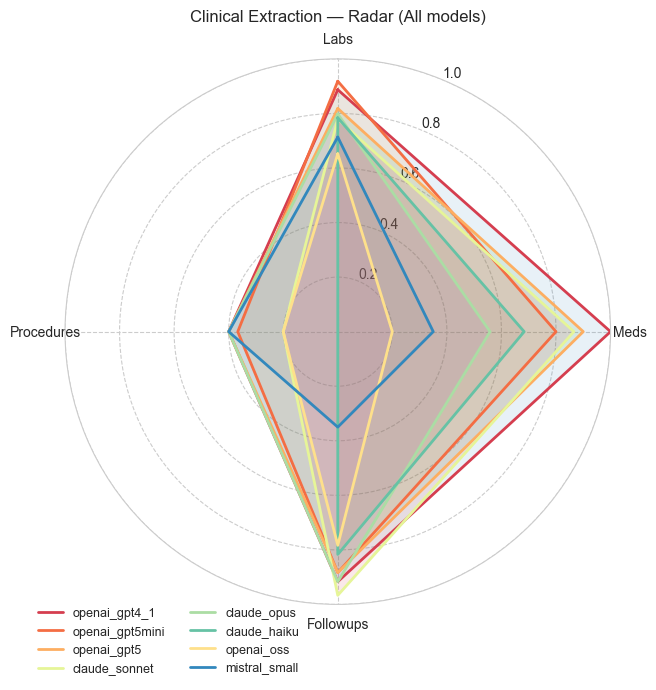

In [38]:
# Create a radar (spider) plot for the top-4 models by overall All Lists F1.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#rows = [
#    {"model":"openai_gpt4_1",   "labs_f1":0.886941, "meds_f1":1.000000, "followups_f1":0.916667, "procedures_f1":0.400000, "all_lists_f1":0.936776},
#    {"model":"openai_gpt5mini", "labs_f1":0.918137, "meds_f1":0.800000, "followups_f1":0.883333, "procedures_f1":0.366667, "all_lists_f1":0.908050},
#    {"model":"openai_gpt5",     "labs_f1":0.818260, "meds_f1":0.900000, "followups_f1":0.883333, "procedures_f1":0.400000, "all_lists_f1":0.894113},
#    {"model":"claude_sonnet",   "labs_f1":0.779365, "meds_f1":0.865714, "followups_f1":0.966667, "procedures_f1":0.200000, "all_lists_f1":0.844437},
#    {"model":"claude_opus",     "labs_f1":0.797911, "meds_f1":0.558333, "followups_f1":0.916667, "procedures_f1":0.400000, "all_lists_f1":0.772567},
##    {"model":"claude_haiku",    "labs_f1":0.783974, "meds_f1":0.683333, "followups_f1":0.816667, "procedures_f1":0.000000, "all_lists_f1":0.694211},
#    {"model":"openai_oss",      "labs_f1":0.652020, "meds_f1":0.200000, "followups_f1":0.783333, "procedures_f1":0.200000, "all_lists_f1":0.574252},
#    {"model":"mistral_small",   "labs_f1":0.713253, "meds_f1":0.350000, "followups_f1":0.350000, "procedures_f1":0.400000, "all_lists_f1":0.567656},
#]
#df = pd.DataFrame(rows).sort_values("all_lists_f1", ascending=False).reset_index(drop=True)

palette = {
    "openai_gpt4_1":   "#d53e4f",  # orange
    "openai_gpt5mini": "#f46d43",  # blue
    "openai_gpt5":     "#fdae61",  # green
    "openai_oss":      "#fee08b",  # light blue
    "claude_sonnet":   "#e6f598",  # magenta
    "claude_opus":     "#abdda4",  # reddish-orange
    "claude_haiku":    "#66c2a5",  # yellow
    "mistral_small":   "#3288bd",  # gray
}


# Choose top-4 models for readability
topk = 8
df_top = df.head(topk)

cats = ["Labs", "Meds", "Followups", "Procedures"]
vals = df_top[["labs_f1","meds_f1","followups_f1","procedures_f1"]].values

# Radar setup
N = len(cats)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

# Grid and ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=cats)
ax.set_ylim(0, 1.0)

# Plot each model
for i, row in df_top.iterrows():
    values = row[["labs_f1","meds_f1","followups_f1","procedures_f1"]].tolist()
    values += values[:1]
    color=palette[row['model']]
    ax.plot(angles, values, color=color, linewidth=2, label=row["model"])
    ax.fill(angles, values, alpha=0.10)

ax.set_title("Clinical Extraction — Radar (All models)", va='bottom')
ax.legend(loc="lower right", bbox_to_anchor=(0.45, -0.15), ncol=2, frameon=False, fontsize=9)

#out_path = "/mnt/data/extraction_radar_top4.png"
plt.tight_layout()
#plt.savefig(out_path, dpi=200, bbox_inches="tight")

#out_path
